# k-Nearest Neighbours 

The kNN algorithm is simple - given a labeled sample set data, and a new sample, predict the label of this sample by using majority vote (or averaging) over the labels of the k-nearest neighbour of the new data in the sample set.

For this task, we assume each data point is an n-dimensional point in $\mathbb{R}^n$, and each label is either 0 or 1.

We use simple Euclidean distance to measure the distance between two points. In case two points in the training have the same distance from a given point to predict, the nearest would be the one appearing first in the training set. 

We use majority vote between all kNN of a point to predict its label. In case the vote of all kNN is tied, the prediction is random.

In [1]:
import numpy as np
from scipy.stats import mode

import matplotlib.pyplot as plt
plt.style.use("bmh")

from sklearn.model_selection import train_test_split

### K-Nearest Neighbor from scratch

In [2]:
class kNNClassifier:
    
    def __init__(self, n_neighbors):
        '''
        n_neighbors: hyper parameter of how many neighbors we use to classify
        '''
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        '''
        Fit/train model
        X: a matrix of data values (rows are samples, columns are attributes)
        y: a vector of corresponding target values
        '''
        self.X = X
        self.y = np.array(y)

    def predict(self, X):
        '''
        Predict class labels using fitted/trained model
        X: a matrix of data values (rows are samples, columns are attributes)
        '''
        # create_dist matrix
        broadcast_mat = np.expand_dims(X , axis=1) - self.X
        # get distance per item
        dist_mat = np.linalg.norm(broadcast_mat, axis=-1)
        # get n_neighbors nearest neighbors labels
        label_counts = self.y[np.argpartition(dist_mat, self.n_neighbors)[:,:self.n_neighbors]]
        # return the most common label for each point
        return mode(label_counts, axis=1).mode.flatten()


In [3]:
def true_boundary_voting_pred(x, y):
    return y-0.1*((x-5)**3-x**2+(x-6)**2+80)

def generate_data(m, seed=None):
    # if seed is not None, this function will always generate the same data
    np.random.seed(seed) 
    X = np.random.uniform(low=0.0, high=10.0, size=(m,2))
    y = np.sign(true_boundary_voting_pred(X[:,0], X[:,1]))
    y[y==0] = 1
    samples_to_flip = np.random.randint(0,m//10)
    flip_ind = np.random.choice(m, samples_to_flip, replace=False)
    y[flip_ind] = -y[flip_ind]
    return X, y

def plot_labeled_data(X, y):
    a = (y==1)
    b = (y==-1)
    plt.scatter(X[a,0], X[a,1], c='r')
    plt.scatter(X[b,0], X[b,1], c='b')

    plt.xlim([0, 10]);
    plt.ylim([0, 10]);
    plt.plot(np.linspace(0,10,1000), -true_boundary_voting_pred(np.linspace(0,10,1000), np.zeros(1000)), linewidth=2, c='k')

## Evaluate kNN algorithm on artificial data
kNN is a **non-parametric** in the sense that no inner parameter of the model is learned by the sample training set (or maybe you could say that the number of parameters increases with the size of the sample set). However, the number of neighbours **k is considered a hyper-parameter**, and choosing the optimal value for it, is choosing the balance between bias and variance.

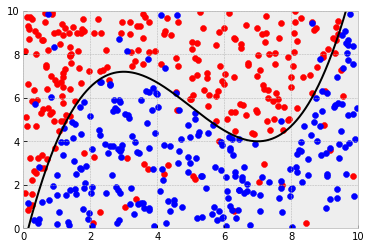

In [4]:
display_X, display_y = generate_data(m=500, seed=42)
plot_labeled_data(display_X, display_y)

In [5]:
X, y = generate_data(m=10000, seed=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

### Train on training set
We split our data in to a training set and a test set.

[]

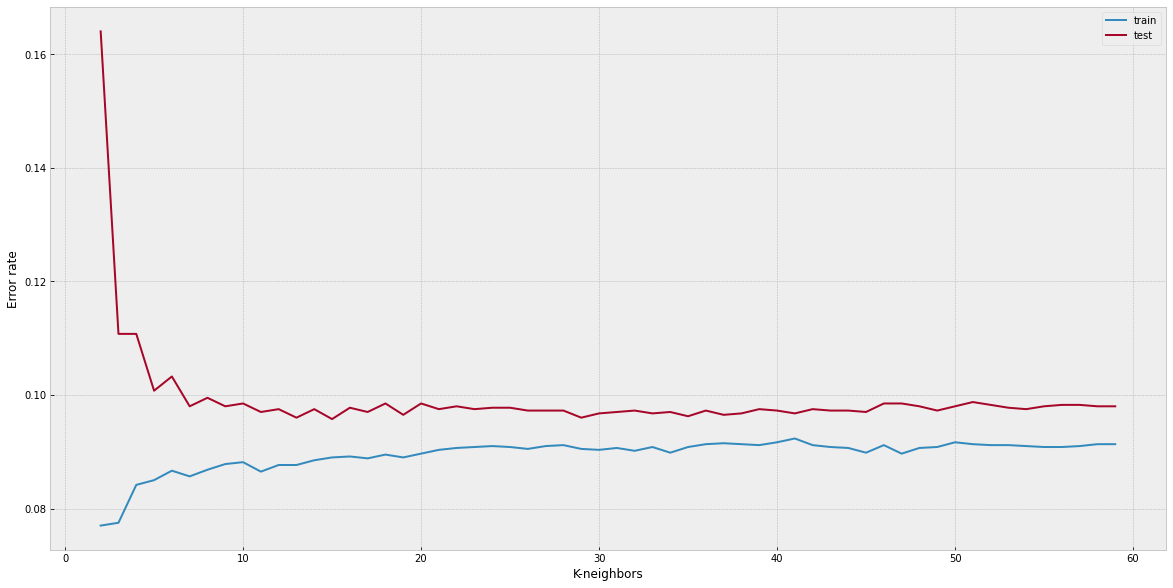

In [6]:
train_err = []
test_err = []
k_list = [i for i in range(2, 60, 1)]
for k in k_list:
    knn = kNNClassifier(k)
    knn.fit(X_train, y_train)

    train_err.append(sum(knn.predict(X_train) != y_train) / y_train.shape[0])
    test_err.append(sum(knn.predict(X_test) != y_test) / y_test.shape[0])

plt.figure(figsize=(20,10))
train, = plt.plot(k_list, train_err, label='train')
test, = plt.plot(k_list, test_err, label='test')
plt.legend(handles=[train, test])
plt.xlabel('K-neighbors')
plt.ylabel('Error rate')
plt.plot()

We can see that the test error quickly goes to slightly over 0.09 and seems pretty stable there. The train set also stabalizes relatively quickly and seems to stay stable once we pass about k=20. This would mean that we can saftely use most k's in the 20-60 range and get a good result. Lets add in cross validation and see what happens.

### Using manual cross validation (k-fold)

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. The goal of cross-validation is to test the model's ability to predict new data that was not used in estimating it, in order to flag problems like overfitting or selection bias and to give an insight on how the model will generalize to an independent dataset. 
We achieve this by setting aside a percentage of the training data and dont train on it. We then train the model and test it on the data we set aside. We do this multiple times each time testing on the set aside data.  

Text(0, 0.5, 'Error rate')

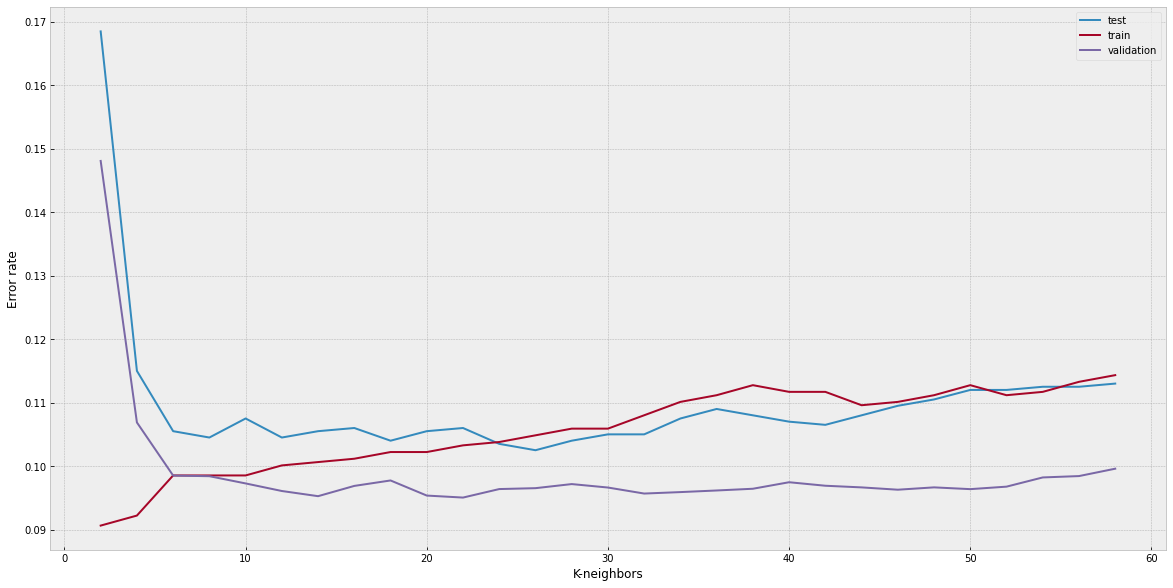

In [7]:
val_err = []
test_err = []
train_err = []
k_list = [i for i in range(2, 60, 2)]
CV = 5
for k in k_list:
    val_err_sum = 0
    test_err_sum = 0
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    for cv in range(CV):
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
        knn = kNNClassifier(k)
        knn.fit(X_train, y_train)
        
        val_err_sum += sum(knn.predict(X_val) != y_val) / y_val.shape[0]

    val_err.append(val_err_sum / CV)
    train_err.append(sum(knn.predict(X_train) != y_train) / y_train.shape[0])
    test_err.append(sum(knn.predict(X_test) != y_test) / y_test.shape[0])
 
plt.figure(figsize=(20,10))
test, = plt.plot(k_list, test_err, label='test')
train, = plt.plot(k_list, train_err, label='train')
val, = plt.plot(k_list, val_err, label='validation')
plt.legend(handles=[test, train, val])
plt.xlabel('K-neighbors')
plt.ylabel('Error rate')

Now we can see a similar but slightly different pciture. Our test and validation stabilize at a minimum between k=15 to k=30 but after that all the erros rates seem to start increasing. For optimal results keeping k between 15-30 would probably be best. 